# NLP track project


The goal of this project is to guide you through the latest techniques in NLP, we have chosen to frame that journey around the problem of *Machine Translation*, More specifically english-spanish translation. 

The motivation for centering around this particular problem is that it's a complex one that has been revolutionized lately. So It will guide you from the basics to the latest SOA techniques.

The reason we choose English and Spanish is purely because we happen to know both of them, if you would like to explore other language feel free to do so but make sure you have a proper dataset that you can use.

## 1. Baseline

As a baseline we will first train a simple encoder-decoder architecture. The code is based on the [seq2seq notebook](https://github.com/fastai/course-nlp/blob/master/7-seq2seq-translation.ipynb) from the [lesson 12](https://www.youtube.com/watch?v=IfsjMg4fLWQ&list=PLtmWHNX-gukKocXQOkQjuVxglSDYWsSh9&index=13&t=0s) of the Fast.ai's NLP course.

### 1.1 Dataset

The dataset we will use was build by [Open Subtitles](https://www.opensubtitles.org/) and consists of movie and series subtitles, we chose this dataset over the alternatives because it contains casual and more simple language than the alternatives (UN resolutions, EU parlament sessions, etc). You can look at the alternatives on this [amazing site](http://opus.nlpl.eu/).

Unfurtunately the spanish used is from Spain, not sure why the Latin American version of the subtitles is not available.

The dataset is extremely large and not in a great format, you can see how we processed it on [this notebook](./subtitles-download.ipynb). There is no need to run it, the resulting csv should be available in [???]

In [1]:
import pandas as pd
from fastai.text import *

base_path = Path('/data/NLP_track/')

In [1]:
df = pd.read_csv(base_path/'subtitles.csv')

/home/javiber/.local/share/virtualenvs/javiber-jarMRqt3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
print(len(df))
df.sample(5)

7990657


,files,sub_id,en,es
4110809,en/2012/2258931/4514437.xml#es/2012/2258931/46...,151,"Well , if that were the case , we 'd usually s...","Bueno , si ese fuera el caso , veríamos un pat..."
508410,en/1987/92549/5463100.xml#es/1987/92549/572373...,29,Escape From Miami,# Escapa ... # # ...
2012222,en/2009/1280095/3628989.xml#es/2009/1280095/51...,520,""" Unable to apprehend perp . """,Imposible detener al autor .
3022683,en/2011/1683844/4233569.xml#es/2011/1683844/43...,435,I don 't fuckin ' think so !,¡ No lo creo !
4900528,en/2013/2670084/4810820.xml#es/2013/2670084/48...,191,"My dance card 's full , and I 'm a woman .",Mi tarjeta está llena y soy una mujer .


In [9]:
df.isna().sum()

files     0
sub_id    0
en        8
es        6
dtype: int64

In [10]:
df.dropna(inplace=True)
df.isna().sum()

files     0
sub_id    0
en        0
es        0
dtype: int64

In [11]:
df = df.sample(100000, random_state=42)

### 1.2 Tokenization and Numericalization

Unfurtunately the dataset was already tokenized, that's why you see spaces around punctuation marks. Not a big deal but we'd have rather the raw messages.

Anyway for this baseline we will use the default settings from fast.ai which is to use spaCy's tokenizer.

#### 1.2.1 Data collate

In order to run the RNN in parallel for a whole batch, all examples in a batch must have the same size. 
To accomplish this we'll add padding where necessary.

In [2]:
def seq2seq_collate(samples, pad_idx=1, pad_first=True, backwards=False):
    "Function that collect samples and adds padding. Flips token order if needed"
    samples = to_data(samples)
    max_len_x = max([len(s[0]) for s in samples])
    max_len_y = max([len(s[1]) for s in samples])
    
    # create matrices of the target size we want (batch_lenght x max_sentence_lenght_in_batch) full of padding
    res_x = torch.zeros(len(samples), max_len_x).long() + pad_idx
    res_y = torch.zeros(len(samples), max_len_y).long() + pad_idx
    
    if backwards: 
        pad_first = not pad_first
    
    for i, s in enumerate(samples):
        # replace the part of the correct part of the padded matrices with the actual values
        if pad_first: 
            res_x[i, -len(s[0]):] = LongTensor(s[0])
            res_y[i, -len(s[1]):] = LongTensor(s[1])
        else:         
            res_x[i,:len(s[0]):] = LongTensor(s[0])
            res_y[i,:len(s[1]):] = LongTensor(s[1])
            
    if backwards: 
        res_x,res_y = res_x.flip(1),res_y.flip(1)
    
    return res_x,res_y

#### 1.2.2 Custom databunch

On the training set, we don't want to mix really long senteces with really short because that'd create lots of padding, instead we'll use fast.ai's `SortishSampler` to keep the sentences of a batch relatively the same size while also having some randomization.

In [3]:
class Seq2SeqDataBunch(TextDataBunch):
    "Create a `TextDataBunch` suitable for training an RNN classifier."
    
    @classmethod
    def create(
            cls, train_ds, valid_ds, test_ds=None, path:PathOrStr='.', bs:int=32, val_bs:int=None, pad_idx=1,
           dl_tfms=None, pad_first=False, device:torch.device=None, no_check:bool=False, backwards:bool=False, 
            **dl_kwargs) -> DataBunch:
        """
        Function that transform the `datasets` in a `DataBunch` for classification. 
        Passes `**dl_kwargs` on to `DataLoader()`
        """
        
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = bs if val_bs is None else val_bs 
        
        collate_fn = partial(seq2seq_collate, pad_idx=pad_idx, pad_first=pad_first, backwards=backwards)
        
        # Sample data randomly but trying to keep the lenghts similar
        train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0].data), bs=bs//2)
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **dl_kwargs)
        dataloaders = [train_dl]
        
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key=lengths.__getitem__)
            
            dataloaders.append(DataLoader(ds, batch_size=val_bs, sampler=sampler, **dl_kwargs))
            
        return cls(*dataloaders, path=path, device=device, collate_fn=collate_fn, no_check=no_check)
    
    
class Seq2SeqTextList(TextList):
    _bunch = Seq2SeqDataBunch
    _label_cls = TextList

In [ ]:
src = (Seq2SeqTextList
       .from_df(df, path=base_path, cols='en')
       .split_by_rand_pct(seed=42)
       .label_from_df(cols='es', label_cls=TextList))

#### 1.2.3 Analyze sentence length
Some sentences are extremely large so we will remove those outliers

In [10]:
x_lengths = [len(o) for o in src.train.x.items] + [len(o) for o in src.valid.x.items]
np.percentile(x_lengths, 90), np.max(x_lengths)

(18.0, 81)

In [11]:
y_lengths = [len(o) for o in src.train.y.items] + [len(o) for o in src.valid.y.items]
np.percentile(y_lengths, 90), np.max(y_lengths)

(17.0, 79)

In [12]:
src = src.filter_by_func(lambda x,y: len(x) > 10 or len(y) > 20)

In [13]:
len(src.train) + len(src.valid)

60315

#### 1.2.4 View results

In [4]:
bs = 64

In [15]:
data = src.databunch(bs=bs)


In [16]:
data.show_batch()

text,target
xxbos xxmaj it 's the chemical formula for xxunk .,xxbos xxmaj es la fórmula química del xxunk .
"xxbos xxmaj oh , that 's what you think !","xxbos o , eso es lo que crees !"
xxbos xxmaj you don ' t have to wait .,xxbos xxmaj no tienes que esperar .
xxbos xxmaj marc xxmaj torres is on another date .,xxbos xxmaj marc xxmaj torres está en otra cita .
"xxbos xxmaj xxunk , this is a complete xxunk ..","xxbos xxmaj xxunk , este es un completo xxunk ..."


**TODO:** how does fastai know which tokenizer to use? is it using english tokenizer on spanish?

In [17]:
data.save()

#### 1.2.4 Load saved databunch

In [5]:
data = load_data(base_path, bs=bs)

### 1.3 Embeddings

We will use the embedings from [fastText](https://fasttext.cc/docs/en/support.html) because they have pretrained models that are good enough for our baseline.

#### 1.3.1 Download pretrained word vectors

In [ ]:
# ! wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz -P {path}
# ! wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.es.300.bin.gz -P {path}

In [ ]:
# ! gunzip {path}/cc.en.300.bin.gz
# ! gunzip {path}/cc.es.300.bin.gz

In [18]:
import fasttext as ft

In [19]:
es_vecs = ft.load_model(str((base_path/'cc.es.300.bin')))
en_vecs = ft.load_model(str((base_path/'cc.en.300.bin')))

In [20]:
def create_emb(vecs, itos, em_sz=300, mult=1.):
    emb = nn.Embedding(len(itos), em_sz, padding_idx=1)
    wgts = emb.weight.data
    vec_dic = {w: vecs.get_word_vector(w) for w in vecs.get_words()}
    miss = 0
    for i, w in enumerate(itos):
        try: 
            wgts[i] = tensor(vec_dic[w])
        except: 
            miss += 1
    print(f'{miss} missing words')
    return emb

emb_enc = create_emb(en_vecs, data.x.vocab.itos)
emb_dec = create_emb(es_vecs, data.y.vocab.itos)

emb_enc.weight.size(), emb_dec.weight.size()

67 missing words
132 missing words


(torch.Size([9168, 300]), torch.Size([11656, 300]))

**NOTE**: the words in our vocabulary that are missing on the fasText's one will be set to random vectors

In [21]:
torch.save(emb_enc, base_path/'en_emb.pth')
torch.save(emb_dec, base_path/'es_emb.pth')

#### 1.3.2 Load saved embeddings

In [6]:
emb_enc = torch.load(base_path/'en_emb.pth')
emb_dec = torch.load(base_path/'es_emb.pth')

### 1.4 Model

The Model we will use is the classic Encoder-Decoder, using a GRU to encode the meaning of the sentence in the original language into a fixed-size vector that the decode will convert into the target language, hopefully conservint the meaning.

In [7]:
class EncDecRNN(nn.Module):
    def __init__(self, emb_enc, emb_dec, nh, out_sl, nl=2, bos_idx=0, pad_idx=1):
        super().__init__()
        
        self.nl, self.nh, self.out_sl = nl, nh, out_sl
        self.bos_idx, self.pad_idx = bos_idx, pad_idx
        self.em_sz_enc = emb_enc.embedding_dim
        self.em_sz_dec = emb_dec.embedding_dim
        self.voc_sz_dec = emb_dec.num_embeddings
                 
        self.emb_enc = emb_enc
        self.emb_enc_drop = nn.Dropout(0.15)
        self.gru_enc = nn.GRU(
            self.em_sz_enc, nh, num_layers=nl, dropout=0.25, batch_first=True)
        self.out_enc = nn.Linear(nh, self.em_sz_dec, bias=False)
        
        self.emb_dec = emb_dec
        self.gru_dec = nn.GRU(
            self.em_sz_dec, self.em_sz_dec, num_layers=nl, dropout=0.1, batch_first=True)
        
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(self.em_sz_dec, self.voc_sz_dec)
        self.out.weight.data = self.emb_dec.weight.data
        
        self.tf_weight = 0  # teacher forcing weight
        
    def encoder(self, bs, inp):
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        _, h = self.gru_enc(emb, h)
        h = self.out_enc(h)
        return h
    
    def decoder(self, dec_inp, h):
        emb = self.emb_dec(dec_inp).unsqueeze(1)
        outp, h = self.gru_dec(emb, h)
        outp = self.out(self.out_drop(outp[:,0]))
        return outp, h
        
    def forward(self, inp, targ=None):
        bs, sl = inp.size()
        h = self.encoder(bs, inp)
        dec_inp = inp.new_zeros(bs).long() + self.bos_idx
        
        res = []
        for i in range(self.out_sl):
            outp, h = self.decoder(dec_inp, h)
            dec_inp = outp.max(1)[1]
            res.append(outp)
            if (dec_inp==self.pad_idx).all(): 
                break
                
            # Teacher forcing
            if (targ is not None) and (random.random() < self.tf_weight):
                if i>=targ.shape[1]: continue
                dec_inp = targ[:,i]
        return torch.stack(res, dim=1)
    
    def initHidden(self, bs): 
        return one_param(self).new_zeros(self.nl, bs, self.nh)

In [ ]:
xb, yb = next(iter(data.valid_dl))
xb.shape

In [ ]:
rnn = EncDecRNN(emb_enc, emb_dec, 256, 20)
rnn

In [ ]:
class TeacherForcing(LearnerCallback):
    "Callback used to redice tf_weight on each epoch"
    def __init__(self, learn, end_epoch):
        super().__init__(learn)
        self.end_epoch = end_epoch
    
    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        if train: return {'last_input': [last_input, last_target]}
    
    def on_epoch_begin(self, epoch, **kwargs):
        self.learn.model.tf_weight = max(1 - epoch/self.end_epoch, 0)
        
class TF_metric(Callback):
    "Callback to print teacher forcing weight during training"
    def __init__(self, model):
        self.name = 'tf_weight'
        self.model = model
        
    def on_epoch_end(self, last_metrics, **kwargs):
        return add_metrics(last_metrics, self.model.tf_weight)

### 1.6 Metrics and loss functions

#### 1.6.1 Cross-Entropy loss

In [7]:
def cross_entropy(out, targ, pad_idx=1):
    bs, targ_len = targ.size()
    _, out_len, vs = out.size()
    if targ_len > out_len: 
        out  = F.pad(out, (0, 0, 0, targ_len - out_len, 0, 0), value=pad_idx)
    if out_len > targ_len: 
        targ = F.pad(targ, (0, out_len - targ_len, 0, 0), value=pad_idx)
    return CrossEntropyFlat()(out, targ)

#### 1.6.2 Token-level accuracy 

In [8]:
def seq2seq_acc(out, targ, pad_idx=1):
    bs, targ_len = targ.size()
    _, out_len, vs = out.size()
    if targ_len > out_len: 
        out  = F.pad(out,  (0,0,0,targ_len-out_len,0,0), value=pad_idx)
    if out_len > targ_len: 
        targ = F.pad(targ, (0,out_len-targ_len,0,0), value=pad_idx)
    out = out.argmax(2)
    return (out==targ).float().mean()

#### 1.6.3 BLEU

In [6]:
class NGram():
    def __init__(self, ngram, max_n=5000): 
        self.ngram,self.max_n = ngram,max_n
        
    def __eq__(self, other):
        if len(self.ngram) != len(other.ngram): 
            return False
        return np.all(np.array(self.ngram) == np.array(other.ngram))
    
    def __hash__(self): 
        return int(sum([o * self.max_n**i for i,o in enumerate(self.ngram)]))

def get_grams(x, n, max_n=5000):
    return x if n==1 else [NGram(x[i:i+n], max_n=max_n) for i in range(len(x)-n+1)]

def get_correct_ngrams(pred, targ, n, max_n=5000):
    pred_grams, targ_grams = get_grams(pred, n, max_n=max_n), get_grams(targ, n, max_n=max_n)
    pred_cnt, targ_cnt = Counter(pred_grams), Counter(targ_grams)
    return sum([min(c, targ_cnt[g]) for g, c in pred_cnt.items()]), len(pred_grams)

class CorpusBLEU(Callback):
    def __init__(self, vocab_sz):
        self.vocab_sz = vocab_sz
        self.name = 'bleu'
    
    def on_epoch_begin(self, **kwargs):
        self.pred_len, self.targ_len, self.corrects, self.counts = 0,0,[0]*4,[0]*4
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        last_output = last_output.argmax(dim=-1)
        for pred, targ in zip(last_output.cpu().numpy(), last_target.cpu().numpy()):
            self.pred_len += len(pred)
            self.targ_len += len(targ)
            for i in range(4):
                c, t = get_correct_ngrams(pred, targ, i + 1, max_n=self.vocab_sz)
                self.corrects[i] += c
                self.counts[i]   += t
    
    def on_epoch_end(self, last_metrics, **kwargs):
        precs = [c/t for c,t in zip(self.corrects,self.counts)]
        len_penalty = exp(1 - self.targ_len/self.pred_len) if self.pred_len < self.targ_len else 1
        bleu = len_penalty * ((precs[0]*precs[1]*precs[2]*precs[3]) ** 0.25)
        return add_metrics(last_metrics, bleu)

### 1.5 Training

In [29]:
learn = Learner(
    data, rnn, loss_func=cross_entropy, 
    metrics=[seq2seq_acc, CorpusBLEU(len(data.y.vocab.itos)), TF_metric(rnn)], 
    callback_fns=partial(TeacherForcing, end_epoch=2))

In [30]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


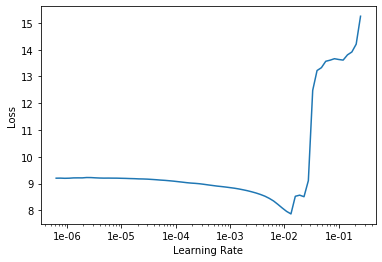

In [31]:
learn.recorder.plot()

In [32]:
learn.fit_one_cycle(4, 1e-2)

epoch,train_loss,valid_loss,seq2seq_acc,bleu,tf_weight,time
0,1.803285,3.466235,0.585295,0.439501,1.000000,00:30
1,2.500406,3.236876,0.545551,0.401979,0.500000,00:27
2,3.120685,3.432822,0.513987,0.342661,0.000000,00:25
3,2.754253,3.059720,0.555680,0.376710,0,00:26


**Note**: the two metrics we are using have issues, in general trying to evaluate how close a sentence is from a target sentence is not an easy problem. 

BLEU has become a standard on the field but it has a lot of limitations. For more info check this great [post](https://towardsdatascience.com/evaluating-text-output-in-nlp-bleu-at-your-own-risk-e8609665a213)

In [33]:
learn.save('baseline')

#### 1.5.1 Load the model

In [16]:
learn.load('baseline');

### 1.6 Cualitative evaluation

In [40]:
# put the model on evaluation mode
learn.model.eval();

In [41]:
learn.model.cpu();

In [70]:
def get_predictions(learn, ds_type=DatasetType.Valid):
    "returns predictions and non-reconstructed activations"
    rxs, rys, rzs, xs, ys, zs = [],[],[],[],[],[]

    with torch.no_grad():
        for xb, yb in progress_bar(learn.dl(DatasetType.Valid)):
            xb = [x.cpu() for x in xb] 
            out = learn.model(*xb)
            yb = yb.cpu()
            out = out.cpu()
            for x, y, z in zip(xb[0], yb, out):
                rxs.append(ds.x.reconstruct(x.int().squeeze(0)))
                rys.append(ds.y.reconstruct(y))
                preds = z.argmax(1)
                rzs.append(ds.y.reconstruct(preds))
                for a,b in zip([xs,ys,zs],[x,y,z]): 
                    a.append(b)
    return rxs,rys,rzs,xs,ys,zs

rxs, rys, rzs, xs, ys, zs = get_predictions(learn)

#### 1.6.1 Nucleus

We will analyze the output using greedy search and nucleus.

In [71]:
from random import choice

def select_nucleus(outp, p=0.5):
    probs = F.softmax(outp,dim=-1)
    idxs = torch.argsort(probs, descending=True)
    res,cumsum = [],0.
    for idx in idxs:
        res.append(idx)
        cumsum += probs[idx]
        if cumsum>p: return idxs.new_tensor([choice(res)])

def decode_with_nucleus(self, inp, targ=None):
    inp = inp[None]
    bs, sl = inp.size()
    h = self.encoder(bs, inp)
    dec_inp = inp.new_zeros(bs).long() + self.bos_idx

    res = []
    for i in range(self.out_sl):
        outp, h = self.decoder(dec_inp, h)
        dec_inp = select_nucleus(outp[0], p=0.3)
        
        res.append(dec_inp)
        if (dec_inp==self.pad_idx).all(): 
            break

        # Teacher forcing
        if (targ is not None) and (random.random() < self.tr_weight):
            if i>=targ.shape[1]: continue
            dec_inp = targ[:,i]
    return torch.stack(res)

def predict_with_nucleus(learn, x, y):
    ds = learn.data.train_ds
    with torch.no_grad():
        out = decode_with_nucleus(learn.model, x)
        rx = ds.x.reconstruct(x)
        ry = ds.y.reconstruct(y)
        rz = ds.y.reconstruct(out.squeeze())
    return rx,ry,rz

In [75]:
for _ in range(10):
    i = np.random.randint(0, len(rxs))
    print(rxs[i])
    print(rzs[i])
#     _, _, nucleus_prediction = predict_with_nucleus(learn, xs[i], ys[i])
#     print(nucleus_prediction)
    print('~'*20)

xxbos xxmaj you got that right .
xxbos xxmaj tienes esa tienes razón .
~~~~~~~~~~~~~~~~~~~~
xxbos xxmaj she was up most of the night .
xxbos xxmaj estaba estado en en vez . noche .
~~~~~~~~~~~~~~~~~~~~
xxbos xxmaj fight them !
xxbos ¡ xxmaj xxunk !
~~~~~~~~~~~~~~~~~~~~
xxbos xxmaj you 're here .
xxbos xxmaj estás aquí .
~~~~~~~~~~~~~~~~~~~~
xxbos a good advice :
xxbos xxmaj un buen buen
~~~~~~~~~~~~~~~~~~~~
xxbos xxmaj thank you .
xxbos xxmaj gracias .
~~~~~~~~~~~~~~~~~~~~
xxbos xxmaj and i 'll go back to hell .
xxbos y voy a infierno .
~~~~~~~~~~~~~~~~~~~~
xxbos xxmaj here .
xxbos xxmaj aquí .
~~~~~~~~~~~~~~~~~~~~
xxbos " xxmaj xxunk "
xxbos " xxmaj xxunk "
~~~~~~~~~~~~~~~~~~~~
xxbos xxmaj so we can ' t go .
xxbos xxmaj xxmaj así podemos podemos hacer a
~~~~~~~~~~~~~~~~~~~~


A lot of different things can be tried to improve this baseline but we don't want to loose too much time on it, some ideas that could be incorporated here are:

- better predictions with [beam search](https://en.wikipedia.org/wiki/Beam_search)
- align batches in a way that allows us to keep h between them? similar to what is done in [notebook 6](https://github.com/fastai/course-nlp/blob/master/6-rnn-english-numbers.ipynb) of fast.ai's course
- Handle UNK better using a sub-word tokenizer like [BPT](https://github.com/rsennrich/subword-nmt) or [SentencePiece](https://github.com/google/sentencepiece)
- train with the full dataset

# Exploring alternatives

Now that we have a basic understanding of the problem we will dive into more novel solutions. On this section is I'll enumerate different alternatives and pick one to try, I encourage you to choose a different one so that we can compare results later.

## 1. Tokenizer and embedding 

FastText was OK for our baseline but there are much better embedings that we can choose, here are the most important ones:

- ULMFit
- ELMO
- BERT
- *Other?* - NLP is in the middle of a revolution, keep an eye on the latest news.

Training one of these more advanced models from scratch is quite lengthy and it might not be possible on the available hardware we have. As a reference, I trained ULMFit from scratch on the whole wikipedia in spanish on a 2080 Ti with 11GB and took ~25hrs ([notebook](./nn-spanish.ipynb)).

For this reason I highly recommend using pre-trained models where possible (for english there are pre-trained weights available for all models but for spanish there might not be available).

## 2. ULMFit with transformers

I will use the embeddings from [ULMFit](https://arxiv.org/pdf/1801.06146.pdf) because I have pretrained models for both languages. As for the model I'll replace our RNN-based encoder-decoder with a [transformer](https://arxiv.org/pdf/1706.03762.pdf) 

### 2.1 English embeddings

We will start with ULMFit's pre-trained model for english and fin-tuned it on our subtitles

In [108]:
path = base_path/'lm_en'

In [104]:
df = pd.read_csv(base_path/'subtitles.csv')
df.dropna(inplace=True)
df = df.sample(100000, random_state=42)

In [ ]:
data_lm = (
    TextList
        .from_df(df, path=path, cols='en')
        .split_by_rand_pct(0.1, seed=42)  # We randomly split and keep 10% (10,000 reviews) for validation
        .label_for_lm()  # We want to do a language model so we label accordingly
        .databunch(bs=48, num_workers=12))

In [106]:
data_lm.save()

In [109]:
data_lm = load_data(path, bs=48)

In [110]:
learn_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult=1.0)
learn_lm.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(9912, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(9912, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1152, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1152, 1152, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1152, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=9912, bias=True)
    (output_dp): RNNDropout()
  )
)

In [7]:
learn_lm.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


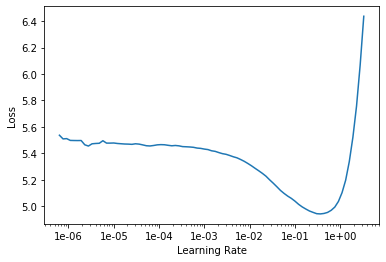

In [8]:
learn_lm.recorder.plot()

In [5]:
learn_lm.fit_one_cycle(2, 1e-1, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.210320,3.822238,0.353517,00:34
1,3.862001,3.547939,0.367578,00:34


In [6]:
learn_lm.save(f'en_fine_tuned_1')

In [7]:
learn_lm.unfreeze()
learn_lm.fit_one_cycle(8, slice(3e-2/(2.6**4), 3e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.554531,3.428349,0.379726,00:45
1,3.490576,3.384338,0.386075,00:45
2,3.396864,3.341999,0.389998,00:46
3,3.303377,3.313029,0.393155,00:46
4,3.182669,3.302203,0.395509,00:46
5,3.035287,3.312927,0.395437,00:46
6,2.885742,3.342957,0.395860,00:46
7,2.799912,3.360027,0.395283,00:46


In [8]:
learn_lm.save(f'en_fine_tuned')
learn_lm.save_encoder(f'en_fine_tuned_enc')

In [111]:
learn_lm.load(f'en_fine_tuned')
learn_lm.load_encoder(f'en_fine_tuned_enc')

In [112]:
encoder = get_model(learn_lm.model)[0]
encoder

AWD_LSTM(
  (encoder): Embedding(9912, 400, padding_idx=1)
  (encoder_dp): EmbeddingDropout(
    (emb): Embedding(9912, 400, padding_idx=1)
  )
  (rnns): ModuleList(
    (0): WeightDropout(
      (module): LSTM(400, 1152, batch_first=True)
    )
    (1): WeightDropout(
      (module): LSTM(1152, 1152, batch_first=True)
    )
    (2): WeightDropout(
      (module): LSTM(1152, 400, batch_first=True)
    )
  )
  (input_dp): RNNDropout()
  (hidden_dps): ModuleList(
    (0): RNNDropout()
    (1): RNNDropout()
    (2): RNNDropout()
  )
)

In [113]:
with open(base_path/'ulm_en_enc.pkl', 'wb') as f:
    torch.save(encoder,f)

### 2.1 Spanish embeddings

We do the same for spanish, in this case the pre-trained spanish LM was trained by me on [this notebook](./nn-spanish.ipynb)

In [114]:
path = base_path/'lm_es'

In [115]:
data_lm_es = (
    TextList
        .from_df(df, path=path, cols='es')
        .split_by_rand_pct(0.1, seed=42)  # We randomly split and keep 10% (10,000 reviews) for validation
        .label_for_lm()  # We want to do a language model so we label accordingly
        .databunch(bs=48, num_workers=12))

NameError: name 'df' is not defined

In [164]:
data_lm_es.save()

In [116]:
data_lm_es = load_data(path, bs=48)

In [117]:
learn_lm_es = language_model_learner(data_lm_es, AWD_LSTM, pretrained_fnames=[f'es_wt', f'es_wt_vocab'], drop_mult=1.0)

In [23]:
learn_lm_es.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


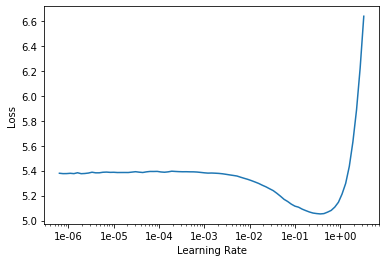

In [24]:
learn_lm_es.recorder.plot()

In [25]:
learn_lm_es.fit_one_cycle(2, 1e-1, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.384515,3.987410,0.345526,00:34
1,3.952792,3.671930,0.362951,00:34


In [26]:
learn_lm_es.save(f'es_fine_tuned_1')

In [27]:
learn_lm_es.unfreeze()
learn_lm_es.fit_one_cycle(8, slice(3e-2/(2.6**4), 3e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.663484,3.546007,0.373406,00:43
1,3.585489,3.476779,0.380818,00:45
2,3.485573,3.434425,0.384581,00:45
3,3.381809,3.411545,0.386838,00:46
4,3.238856,3.415226,0.387385,00:45
5,3.081196,3.432200,0.389833,00:45
6,2.932688,3.467675,0.389468,00:46
7,2.828584,3.491594,0.388710,00:46


In [29]:
learn_lm_es.save(f'es_fine_tuned')
learn_lm_es.save_encoder(f'es_fine_tuned_enc')

In [118]:
learn_lm_es.load(f'es_fine_tuned')
learn_lm_es.load_encoder(f'es_fine_tuned_enc')

In [119]:
encoder = get_model(learn_lm_es.model)[0]
encoder

AWD_LSTM(
  (encoder): Embedding(12656, 400, padding_idx=1)
  (encoder_dp): EmbeddingDropout(
    (emb): Embedding(12656, 400, padding_idx=1)
  )
  (rnns): ModuleList(
    (0): WeightDropout(
      (module): LSTM(400, 1152, batch_first=True)
    )
    (1): WeightDropout(
      (module): LSTM(1152, 1152, batch_first=True)
    )
    (2): WeightDropout(
      (module): LSTM(1152, 400, batch_first=True)
    )
  )
  (input_dp): RNNDropout()
  (hidden_dps): ModuleList(
    (0): RNNDropout()
    (1): RNNDropout()
    (2): RNNDropout()
  )
)

In [120]:
with open(base_path/'ulm_es_enc.pkl', 'wb') as f:
    torch.save(encoder,f)

In [21]:
del learn_lm
del learn_lm_es
del data_lm
del data_lm_es
import gc
gc.collect()
torch.cuda.empty_cache()

### Transformer

In [7]:
class TransformerEmbedding(nn.Module):
    "Embedding + positional encoding + dropout"
    def __init__(self, emb, inp_p=0.):
        super().__init__()
        self.emb_sz = emb.embedding_dim
        self.embed = emb
        self.pos_enc = PositionalEncoding(self.emb_sz)  # https://github.com/fastai/fastai/blob/master/fastai/text/models/transformer.py#L11
        self.drop = nn.Dropout(inp_p)
    
    def forward(self, inp): 
        pos = torch.arange(0, inp.size(1), device=inp.device).float()
        return self.drop(self.embed(inp) * math.sqrt(self.emb_sz) + self.pos_enc(pos))

In [8]:
class EncoderBlock(DecoderLayer):  # https://github.com/fastai/fastai/blob/master/fastai/text/models/transformer.py#L138
    pass


In [9]:
class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads, d_model, d_head=None, p=0., bias=True, scale=True):
        super().__init__()
        d_head = ifnone(d_head, d_model//n_heads)
        self.n_heads,self.d_head,self.scale = n_heads,d_head,scale
        self.q_wgt,self.k_wgt,self.v_wgt = [nn.Linear(
            d_model, n_heads * d_head, bias=bias) for o in range(3)]
        self.out = nn.Linear(n_heads * d_head, d_model, bias=bias)
        self.drop_att,self.drop_res = nn.Dropout(p),nn.Dropout(p)
        self.ln = nn.LayerNorm(d_model)
        
    def forward(self, q, kv, mask=None):
        return self.ln(q + self.drop_res(self.out(self._apply_attention(q, kv, mask=mask))))
    
    def create_attn_mat(self, x, layer, bs):
        return layer(x).view(bs, x.size(1), self.n_heads, self.d_head
                            ).permute(0, 2, 1, 3)
    
    def _apply_attention(self, q, kv, mask=None):
        bs,seq_len = q.size(0),q.size(1)
        wq,wk,wv = map(lambda o: self.create_attn_mat(*o,bs),
                       zip((q,kv,kv),(self.q_wgt,self.k_wgt,self.v_wgt)))
        attn_score = wq @ wk.transpose(2,3)
        if self.scale: attn_score /= math.sqrt(self.d_head)
        if mask is not None: 
            attn_score = attn_score.float().masked_fill(mask, -float('inf')).type_as(attn_score)
        attn_prob = self.drop_att(F.softmax(attn_score, dim=-1))
        attn_vec = attn_prob @ wv
        return attn_vec.permute(0, 2, 1, 3).contiguous().view(bs, seq_len, -1)

class DecoderBlock(nn.Module):
    "Decoder block of a Transformer model."
    #Can't use Sequential directly cause more than one input...
    def __init__(self, n_heads, d_model, d_head, d_inner, p=0., bias=True, scale=True, double_drop=True):
        super().__init__()
        self.mha1 = MultiHeadAttention(n_heads, d_model, d_head, p=p, bias=bias, scale=scale)
        self.mha2 = MultiHeadAttention(n_heads, d_model, d_head, p=p, bias=bias, scale=scale)
        self.ff   = feed_forward(d_model, d_inner, ff_p=p, double_drop=double_drop)
    
    def forward(self, x, enc, mask_out=None): 
        self_att = self.mha1(x, x, mask_out)
        enc_att = self.mha2(self_att, enc)
        return self.ff(enc_att)

In [10]:
class Transformer(Module):
    def __init__(
            self, emb_enc, emb_dec, n_layers=6, n_heads=8, d_model=300, d_head=32, 
            d_inner=1024, p=0.1, bias=True, scale=True, double_drop=True, pad_idx=1):
        
        self.enc_emb = TransformerEmbedding(emb_enc, p)
        self.dec_emb = TransformerEmbedding(emb_dec, 0.)
        
        args = (n_heads, d_model, d_head, d_inner, p, bias, scale, double_drop)
        
        self.encoder = nn.ModuleList([EncoderBlock(*args) for _ in range(n_layers)])
        self.decoder = nn.ModuleList([DecoderBlock(*args) for _ in range(n_layers)])
        
        self.out = nn.Linear(d_model, emb_dec.num_embeddings)
        self.out.weight = self.dec_emb.embed.weight
        self.pad_idx = pad_idx
        
    def forward(self, inp, out):
        mask_out = get_output_mask(out, self.pad_idx)
        
        enc, out = self.enc_emb(inp), self.dec_emb(out)
        
        enc = compose(self.encoder)(enc)
        out = compose(self.decoder)(out, enc, mask_out)
        return self.out(out)

In [10]:
def get_output_mask(inp, pad_idx=1):
    return torch.triu(inp.new_ones(inp.size(1),inp.size(1)), diagonal=1)[None,None].bool()

In [11]:
def shift_tfm(b):
    x,y = b
    y = F.pad(y, (1, 0), value=1)
    return [x, y[:,:-1]], y[:,1:]

data.add_tfm(shift_tfm)

In [16]:
model = Transformer(
    emb_enc=emb_enc, 
    emb_dec=emb_dec)

In [54]:
learn = Learner(
    data, model, 
#     loss_func=cross_entropy, 
    loss_func=FlattenedLoss(LabelSmoothingCrossEntropy, axis=-1),
#     metrics=[seq2seq_acc, CorpusBLEU(len(data.y.vocab.itos))]    
    metrics=[accuracy, CorpusBLEU(len(data.y.vocab.itos))], 
)

In [55]:
torch.cuda.empty_cache()

In [18]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


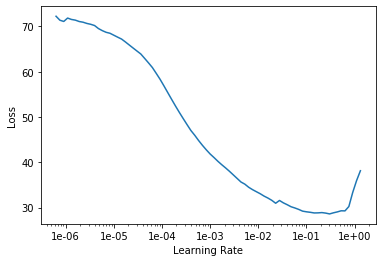

In [19]:
learn.recorder.plot()

In [58]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,bleu,time
0,3.223622,3.672704,0.656608,0.460863,00:44
1,2.490078,3.119509,0.687598,0.497821,00:44
2,2.129917,2.923721,0.707818,0.508725,00:44
3,1.978315,2.917567,0.697411,0.497555,00:44
4,1.880067,2.948939,0.688118,0.486540,00:45


In [61]:
learn.unfreeze()

In [62]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.98E-06
Min loss divided by 10: 3.98E-05


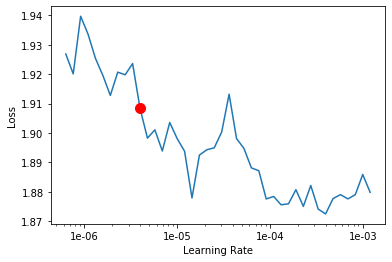

In [77]:
learn.recorder.plot(skip_end=20, suggestion=True)

In [85]:
learn.fit_one_cycle(5, 4e-6)

epoch,train_loss,valid_loss,accuracy,bleu,time
0,1.868427,2.952452,0.687975,0.486179,00:44
1,1.859002,2.948158,0.689888,0.488201,00:44
2,1.853037,2.944450,0.690671,0.489060,00:44
3,1.844827,2.947686,0.690316,0.488790,00:44
4,1.836269,2.947003,0.690882,0.489816,00:44


In [86]:
learn.save('transformer-fastext')

#### umlfit and transformers

In [12]:
class Transformer2(Module):
    def __init__(
            self, out_dim, n_layers=6, n_heads=8, d_model=400, d_head=32, 
            d_inner=1024, p=0.1, bias=True, scale=True, double_drop=True, pad_idx=1):
        
        with open(base_path/'ulm_en_enc.pkl', 'rb') as f:
            self.encoder = torch.load(f)
        
        with open(base_path/'ulm_es_enc.pkl', 'rb') as f:
            self.dec_emb = torch.load(f)
        self.pos_enc = PositionalEncoding(400)
        
        args = (n_heads, d_model, d_head, d_inner, p, bias, scale, double_drop)
        self.decoder = nn.ModuleList([DecoderBlock(*args) for _ in range(n_layers)])
        
        self.out = nn.Linear(d_model, out_dim)
        self.pad_idx = pad_idx
        
    def forward(self, inp, out):
        enc, _ = self.encoder(inp)
        enc = enc[-1]
        out, _ = self.dec_emb(out)
        out = out[-1]
        mask_out = get_output_mask(out, self.pad_idx)
        
        out = compose(self.decoder)(out, enc, mask_out)
        return self.out(out)

In [37]:
ulm_model = Transformer2(len(data.y.vocab.itos))

In [38]:
learn = Learner(
    data, ulm_model, 
#     loss_func=cross_entropy, 
    loss_func=FlattenedLoss(LabelSmoothingCrossEntropy, axis=-1),
#     metrics=[seq2seq_acc, CorpusBLEU(len(data.y.vocab.itos))]    
    metrics=[accuracy, CorpusBLEU(len(data.y.vocab.itos))], 
)

In [22]:
requires_grad(learn.model.encoder, False)

In [23]:
requires_grad(learn.model.dec_emb, False)

In [15]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


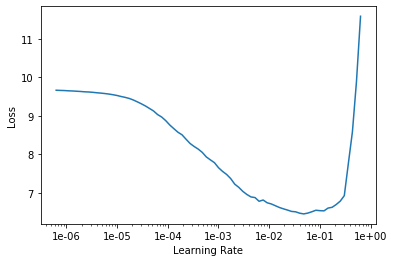

In [16]:
learn.recorder.plot()

In [17]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,bleu,time
0,2.822903,2.830521,0.708963,0.470336,01:11
1,2.529584,2.564392,0.754046,0.533648,01:11
2,2.402332,2.393408,0.778947,0.565763,01:12
3,2.257052,2.312717,0.794041,0.585411,01:11
4,2.171962,2.293389,0.797113,0.590038,01:12


In [18]:
learn.save('uml-transformer-1')

In [39]:
learn.load('uml-transformer-1');